In [1]:
import os
import sys
sys.path.append("../../..")
from nebula.plots import readCrossValidationMetricFile

# plot aucs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_auc(aucs, ax=None):
    df = pd.DataFrame(aucs).transpose()
    x = df.index.values
    y = df.mean(axis=1).values
    yerr = df.std(axis=1).values
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(12,6))
    ax.errorbar(x, y, yerr=yerr, capsize=5, capthick=2, elinewidth=2, label="train")
    ax.scatter(x, y)
    return ax

def plot_metric(train_metrics, key="tpr", ax=None, linestyle=None):
    avg = pd.DataFrame({x: train_metrics[x][f"{key}_avg"] for x in train_metrics})
    std = pd.DataFrame({x: train_metrics[x][f"{key}_std"] for x in train_metrics})
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(12,6))
    for col in avg.columns:
        x = avg.index.values
        y = avg[col].values
        yerr = std[col].values
        ax.errorbar(x, y, yerr=yerr, label=col, capsize=3, linestyle=linestyle)
        ax.scatter(x, y)
    return ax

In [2]:
# get dirs from current folder
dirs = [x for x in os.listdir() if "_16" in x and "Run" not in x]
train_metrics = {}
val_metrics = {}
train_aucs = {}
val_aucs = {}
epoch_times = {}
for d in dirs:
    key = d.split("_")[0]
    if "TransformerEncoder" in key:
            key = key.replace("Encoder", "").replace("Model", "").replace("WithChunking", " (splits)")
    train_metrics[key], train_aucs[key], _ = readCrossValidationMetricFile(os.path.join(d, "metrics_training.json"))
    val_metrics[key], val_aucs[key], epoch_times[key] = readCrossValidationMetricFile(os.path.join(d, "metrics_validation.json"))

In [20]:
# reorder keys based on list
keys = ["Cnn1DLinear", "Transformer (splits)", "Transformer", "LSTM", "ReformerLM"]
train_metrics = {k: train_metrics[k] for k in keys}
val_metrics = {k: val_metrics[k] for k in keys}
train_aucs = {k: train_aucs[k] for k in keys}
val_aucs = {k: val_aucs[k] for k in keys}
epoch_times = {k: epoch_times[k] for k in keys}

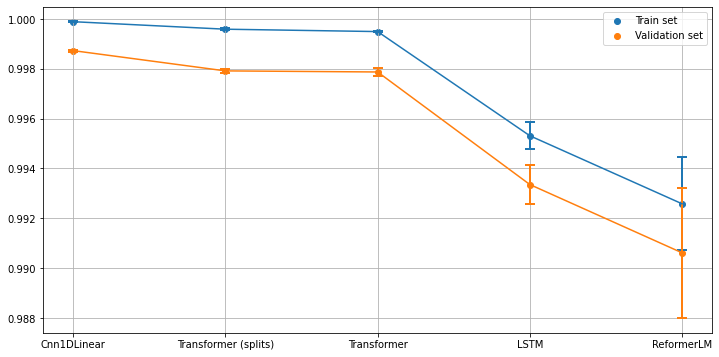

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.grid()
ax = plot_auc(train_aucs, ax)
ax = plot_auc(val_aucs, ax)
_ = ax.legend(["Train set", "Validation set"])

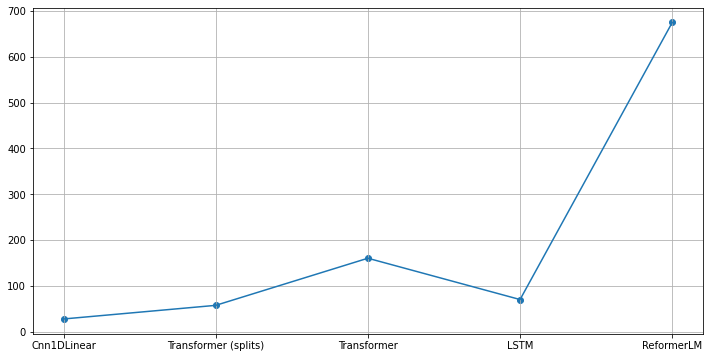

In [38]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.grid()
# plot epoch_times keys as x, values as y in scatter/lineplot
ax.scatter(list(epoch_times.keys()), list(epoch_times.values()))
_ = ax.plot(list(epoch_times.keys()), list(epoch_times.values()))

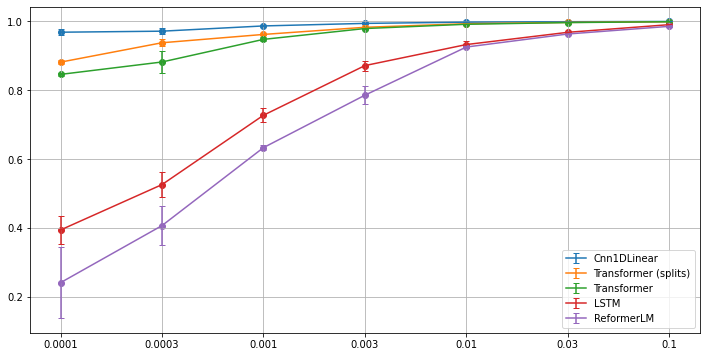

In [22]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax = plot_metric(train_metrics, "tpr", ax = ax)
ax.legend()
ax.grid()
#ax = plot_metric(val_metrics, "tpr", ax = ax, linestyle="dashed")

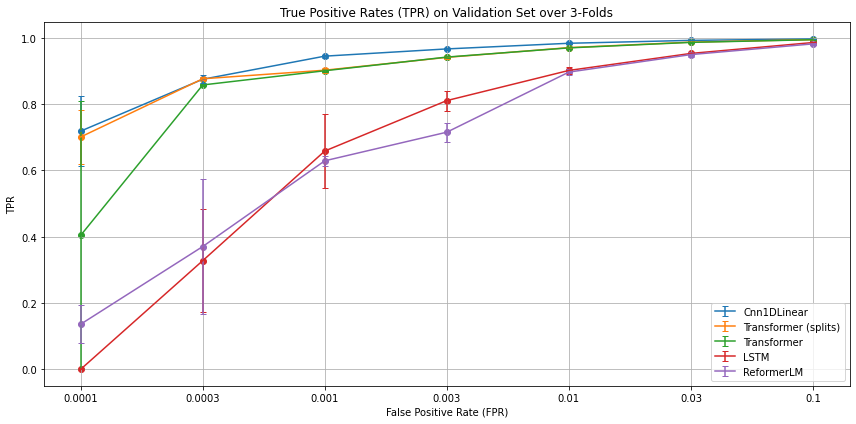

In [26]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax = plot_metric(val_metrics, "tpr", ax = ax)
ax.legend()
ax.grid()
ax.set_ylabel("TPR")
ax.set_xlabel("False Positive Rate (FPR)")
_ = ax.set_title("True Positive Rates (TPR) on Validation Set over 3-Folds")
fig.tight_layout()
fig.savefig("../../../img/_crossValidationPlots/final_model_eval.png")